In [50]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [51]:
data_ibl = np.load("20240204_1426.npy")
time_ibl = data_ibl[:, 0]
omegaX_ibl = data_ibl[:, 1]
omegaY_ibl = data_ibl[:, 2] * (-1)
omegaZ_ibl = data_ibl[:, 3]

In [52]:
data_1 = np.load("05022024_1.npy")
time_1 = data_1[:, 0]
fi_1 = data_1[:, 1]
theta_1 = data_1[:, 2]
omega_1 = theta_1*3600

In [53]:
data_2 = np.load("05022024_2.npy")
time_2 = data_2[:, 0]
fi_2 = data_2[:, 1]
theta_2 = data_2[:, 2]
omega_2 = theta_2*3600

### Сразу обработаем time_ibl от переполнения

In [54]:
n = 0
delta = 0
for i in range(len(time_ibl)-1):
    if abs(time_ibl[i+1]-time_ibl[i])>2000:
        n += 1
        time_ibl[(i+1):] += (time_ibl[i] - delta)
        delta += (time_ibl[i] - delta)
print(n, " раз переполнилось время на ибл")

14  раз переполнилось время на ибл


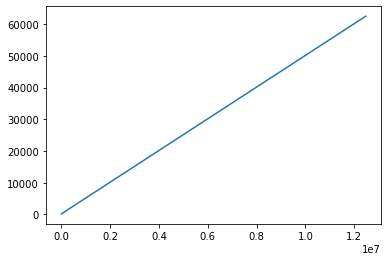

In [55]:
plt.plot([i for i in range(len(time_ibl))], time_ibl)

In [56]:
def cut_peaks(data, n):
    counter = 0
    in_peak = False

    for i in range(len(data)):
        if abs(data[i]) > 1000 and not in_peak:
            in_peak = True
            counter += 1
        elif in_peak and abs(data[i]) < 200:
            in_peak = False
            if counter == n:
                break
    print(data[i-20])
    if counter < n:
        print("Only ", counter, " peaks in data")
        return data
    else:
        return data[:i+1]

In [57]:
def find_points(omega1, omega2, n_peaks, limit):
    counter = 0
    in_peak = False
    same_time = []
    index2 = 0 

    for i in range(len(omega1)):
        if abs(omega1[i]) > limit and not in_peak:
            in_peak = True
            counter += 1
            for j in range(index2, len(omega2), 1):
                if abs(omega2[j]) > limit:
                    same_time.append((i,j))
                    index2 = j
                    break
            
        elif in_peak and abs(omega1[i]) < limit:
            in_peak = False
            for j in range(index2, len(omega2), 1):
                if abs(omega2[j]) < limit:
                    same_time.append((i,j))
                    index2 = j
                    break
            if counter == n_peaks:
                break
    if counter < n_peaks:
        print("Only ", counter, " peaks in data")
    else:
        return same_time

In [58]:
points = find_points(omegaY_ibl, omega_1, 10, 500)

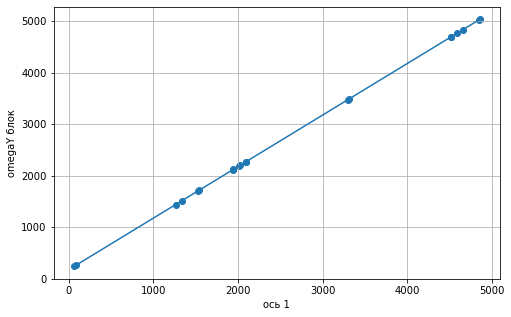

In [59]:
timeibl1 = []
time1 = []
for i in range(len(points)):
    timeibl1.append(time_ibl[points[i][0]])
    time1.append(time_1[points[i][1]])
    
plt.figure(figsize=(8, 5))
plt.plot(time1, timeibl1)
plt.scatter(time1, timeibl1)
plt.grid(True)
plt.xlabel('ocь 1')
plt.ylabel('omegaY блок')
plt.show()

In [60]:
a1, b1 = np.polyfit(time1, timeibl1, 1)
print(f"timeibl = {a1}*time1 + {b1}")

timeibl = 0.999987391242748*time1 + 177.60520982538085


In [61]:
def find_points(omegaX, omegaZ, omega2, n_peaks, limit):
    counter = 0
    in_peak = False
    same_time = []
    index1 = 0 
    indexX = 0
    indexZ = 0

    for i in range(len(omega2)):
        if abs(omega2[i]) > limit and not in_peak:
            in_peak = True
            counter += 1
            for j in range(index1, len(omegaX), 1):
                if abs(omegaX[j]) > limit:
                    indexX = j
                    break
            for k in range(index1, len(omegaZ), 1):
                if abs(omegaZ[k]) > limit:
                    indexZ = k
                    break
            same_time.append((i, min(indexX, indexZ)))
            index1 = min(indexX, indexZ)
            
        elif in_peak and abs(omega2[i]) < limit:
            in_peak = False
            if indexX < indexZ:
                for j in range(index1, len(omegaX), 1):
                    if abs(omegaX[j]) < limit:
                        same_time.append((i,j))
                        index1 = j
                        break
            if indexX > indexZ:
                for k in range(index1, len(omegaZ), 1):
                    if abs(omegaZ[k]) < limit:
                        same_time.append((i,k))
                        index1 = k
                        break
            if counter == n_peaks:
                break
                
    if counter < n_peaks:
        print("Only ", counter, " peaks in data")
    else:
        return same_time

In [62]:
points2 = find_points(omegaX_ibl, omegaZ_ibl, omega_2, 10, 600) #limit больше 500, потому что у икса неортогональности от z

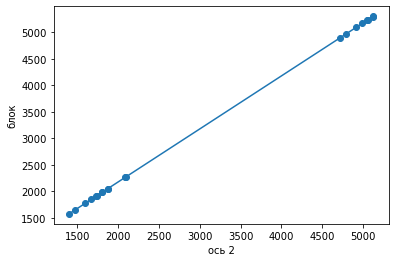

In [63]:
timeibl2 = []
time2 = []
for i in range(len(points2)):
    timeibl2.append(time_ibl[points2[i][1]])
    time2.append(time_2[points2[i][0]])
    
plt.figure()
plt.plot(time2, timeibl2)
plt.scatter(time2, timeibl2)
plt.xlabel("ось 2")
plt.ylabel("блок")
plt.show()

In [64]:
a2, b2 = np.polyfit(time2, timeibl2, 1)
print(f"timeibl = {a2}*time2 + {b2}")

timeibl = 0.9999951022327178*time2 + 179.3270325657494


In [65]:
time_1_2ibl = a1*time_1 + b1
time_2_2ibl = a2*time_2 + b2

In [66]:
def concatenate_axes(time1, time2, fi1, fi2, omega1, omega2, a1, b1, a2, b2):
    #time_1_2ibl = a1*time_1 + b1
    #time_2_2ibl = a2*time_2 + b2

    time12    = np.empty(time1.size + time2.size, dtype=time1.dtype)
    fi1_12    = np.empty(time1.size + time2.size, dtype=time1.dtype) 
    fi2_12    = np.empty(time1.size + time2.size, dtype=time1.dtype)
    omega1_12 = np.empty(time1.size + time2.size, dtype=time1.dtype)
    omega2_12 = np.empty(time1.size + time2.size, dtype=time1.dtype)
    i, j, k = 0, 0, 0

    while i < time1.size and j < time2.size:
        if time1[i] < time2[j]:
            time12[k] = time1[i]
            fi1_12[k] = fi1[i]
            omega1_12[k] = omega1[i]
            fi2_12[k] = 0 if k==0 else fi2_12[k-1]
            omega2_12[k] = 0 if k==0 else omega2_12[k-1]
            i += 1
        else:
            time12[k] = time2[j]
            fi2_12[k] = fi2[j]
            omega2_12[k] = omega2[j]
            fi1_12[k] = 0 if k==0 else fi1_12[k-1]
            omega1_12[k] = 0 if k==0 else omega1_12[k-1]
            j += 1
        k += 1

    # Добавляем оставшиеся элементы
    while i < time1.size:
        time12[k] = time1[i]
        fi1_12[k] = fi1[i]
        omega1_12[k] = omega1[i]
        fi2_12[k] = fi2_12[k-1]
        omega2_12[k] = omega2_12[k-1]
        i += 1
        k += 1

    while j < time2.size:
        time12[k] = time2[j]
        fi2_12[k] = fi2[j]
        omega2_12[k] = omega2[j]
        fi1_12[k] = fi1_12[k-1]
        omega1_12[k] = omega1_12[k-1]
        j += 1
        k += 1
    
    return time12, fi1_12, fi2_12, omega1_12, omega2_12

In [67]:
time12, fi1_12, fi2_12, omega1_12, omega2_12 = concatenate_axes(time_1_2ibl, time_2_2ibl, fi_1, fi_2, omega_1, omega_2, a1, b1, a2, b2)

In [68]:
print(len(time12)//100000)

16


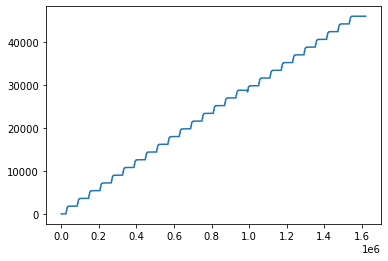

In [69]:
plt.plot([i for i in range(len(fi2_12))], fi2_12)

Первый вариант, общая матрица поворота, неправильно работает()

In [71]:
begin_koord=np.array([[1,0,0],[0,-1,0],[0,0,-1]])

OmegaX = np.array([])
OmegaY = np.array([])
OmegaZ = np.array([])

M12 = np.array([])
ex = begin_koord[:, 0]
ey = begin_koord[:, 1]
ez = begin_koord[:, 2]
fi10, fi1  = 0, 0
fi20, fi2  = 0, 0

Omega_earth = np.array([0, 12.44, 8.42])

file = open('etalon.txt', 'w')
file.write("{:8}".format("time") + "{:17}".format("omega_x,gph") + "{:17}".format("omega_y,gph") + "{:17}".format("omega_z,gph") + '\n')
for i in range(1, len(time12)//1 +1):
    fi10, fi1 = fi_1[i-1], fi_1[i]
    fi20, fi2 = fi_2[i-1], fi_2[i]
    y, z = -ey[1], -ey[2]
    dfi1 = math.radians(fi1-fi10)
    dfi2 = math.radians(fi2-fi20)
    M12 = np.array([[np.cos(dfi1),                                 -(y*np.sin(dfi2)+z*np.cos(dfi2))*np.sin(dfi1),                                    (y*np.cos(dfi2)-z*np.sin(dfi2))*np.sin(dfi1)],
                    [(y*np.sin(dfi2)+z*np.cos(dfi2))*np.sin(dfi1), np.cos(dfi1)+(1-np.cos(dfi1))*(y*np.cos(dfi2)-z*np.sin(dfi2))**2,                 (1-np.cos(dfi1))*(y*np.cos(dfi2)-z*np.sin(dfi2))*(y*np.sin(dfi2)+z*np.cos(dfi2))], 
                    [(z*np.sin(dfi2)-y*np.cos(dfi2))*np.sin(dfi1), (1-np.cos(dfi1))*(y*np.sin(dfi2)+z*np.cos(dfi2))*(y*np.cos(dfi2)-z*np.sin(dfi2)), np.cos(dfi1)+(1-np.cos(dfi1))*(y*np.sin(dfi2)+z*np.cos(dfi2))**2]])
    ex = M12 @ ex
    ey = M12 @ ey
    ez = M12 @ ez
    
    omegax = np.dot(ex, Omega_earth) + omega2_12[i]*ex[0]
    omegay = np.dot(ey, Omega_earth) - omega1_12[i]
    omegaz = np.dot(ez, Omega_earth) + omega2_12[i]*ez[0]
    file.write("{:8.3f}".format(time12[i]) + "{:17.8f}".format(omegax) + "{:17.8f}".format(omegay) + "{:17.8f}".format(omegaz) + '\n')
file.close()

IndexError: index 810396 is out of bounds for axis 0 with size 810396

In [8]:
def build_reference(data_ibl, data_1, data_2, n_peaks=10, limit1=500, limit2=600):
    time_ibl = data_ibl[:, 0]
    omegaX_ibl = data_ibl[:, 1]
    omegaY_ibl = data_ibl[:, 2] * (-1)
    omegaZ_ibl = data_ibl[:, 3]
    time_1 = data_1[:, 0]
    fi_1 = data_1[:, 1]
    theta_1 = data_1[:, 2]
    omega_1 = theta_1*3600
    time_2 = data_2[:, 0]
    fi_2 = data_2[:, 1]
    theta_2 = data_2[:, 2]
    omega_2 = theta_2*3600
    
    correct_time(time_ibl)
    
    points1 = find_points(omegaY_ibl, omega_1, n_peaks, limit1)
    points2 = find_points(omegaX_ibl, omegaZ_ibl, omega_2, n_peaks, limit2)
    
    timeibl1= []
    time1 = []
    for i in range(len(points)):
        timeibl1.append(time_ibl[points[i][0]])
        time1.append(time_1[points[i][1]])
    
    timeibl2 = []
    time2 = []
    for i in range(len(points2)):
        timeibl2.append(time_ibl[points2[i][1]])
        time2.append(time_2[points2[i][0]])
        
    a1, b1 = np.polyfit(time1, timeibl1, 1)
    a2, b2 = np.polyfit(time2, timeibl2, 1)
    
    time12, fi1_12, fi2_12 = concatenate_axes(time_1_2ibl, time_2_2ibl, fi_1, fi_2, a1, b1, a2, b2)
    
    print_reference(time12, fi1, fi2)

In [7]:
begin_koord = np.array([[1,0,0],[0,-1,0],[0,0,-1]])
ex = begin_koord[:, 0]
ex

array([1, 0, 0])